In [3]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import pandas as pd
import numpy as np

import config.settings as cset
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            focus_countries,
                            focus_countries_names,
                            focus_countries_colors, 
                            focus_scenarios_color_dict,
                            focus_scenarios_labels,
                            cmap_diverging
                            )

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgba

from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import kstest
from scipy.stats import ks_2samp


plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['ps.fonttype'] = 'truetype'

## Load Data

a. GMT data

In [4]:
gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)

b. GDP data

In [5]:
gdp_df   = pd.read_csv(cset.file_burke).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2', 'SSP2_clim']]
gdp_df = gdp_df[gdp_df.scen != 'Ref1p5']
gdp_df.loc[gdp_df.scen == 'Refv2', 'scen'] = 'Ref'
gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)

## Analysis

### Step 1: GDP development over time

In [6]:
# estimate GDP development 
def q1(x):
    return x.quantile(0.1)
def q9(x):
    return x.quantile(0.9)

def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)
# derive differences
gdp_ref = gdp_df[gdp_df.scen == 'Ref'].copy()
gdp_neg = gdp_df[gdp_df.scen == 'Neg'].copy()
gdp_gs = gdp_df[gdp_df.scen == 'GS'].copy()

# derive timeseries of of 10th, median and 90th percentile: 
f = {'diff_SSP2': ['median', 'std', q1, q9, q05, q95]}
gdp_ref_agg = gdp_ref.loc[:, ['year', 'diff_SSP2']].groupby('year').agg(f).loc[:, 'diff_SSP2'].copy()
gdp_neg_agg = gdp_neg.loc[:, ['year', 'diff_SSP2']].groupby('year').agg(f).loc[:, 'diff_SSP2'].copy()

In [7]:
ref_quantiles = np.quantile(gdp_ref[gdp_ref.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
neg_quantiles = np.quantile(gdp_neg[gdp_neg.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
gs_quantiles = np.quantile(gdp_gs[gdp_gs.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100

In [8]:
(gs_quantiles - neg_quantiles)/neg_quantiles*100

array([-14.32364797, -13.95459005, -12.91043163, -12.05044272,
       -10.99125891, -10.41414734,  -9.71011069,  -8.12159344,
        -6.41568614,  -4.82937609,  -3.78475559,  -2.34713128,
        -1.40599959,  -0.82356966,  -0.56640127,   0.13632984,
         0.92908806,   0.64012065,   1.06043393])

In [7]:
(gs_quantiles - ref_quantiles)/ref_quantiles*100

array([-23.4223847 , -20.95366285, -18.90821534, -16.99959823,
       -15.8889471 , -14.59230265, -13.27172436, -11.55705569,
        -9.42645036,  -7.2733438 ,  -5.68416123,  -3.73104536,
        -2.58128653,  -1.95604354,  -1.58763269,  -0.09526619,
         1.85891911,   3.99229525,   6.33524561])

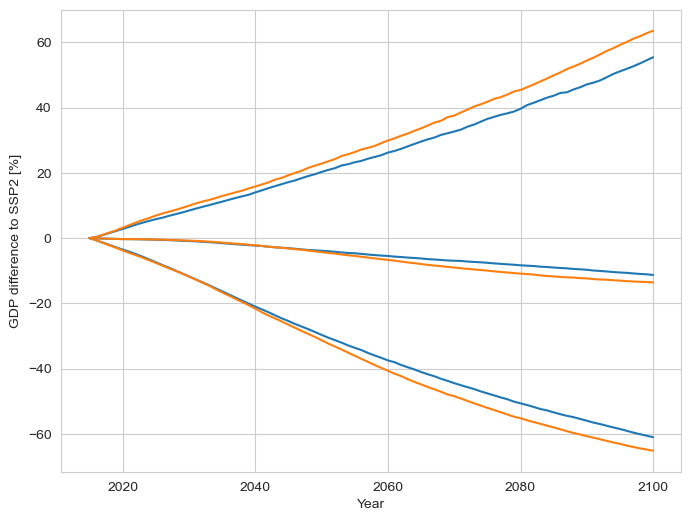

In [9]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ((gdp_ref_agg.loc[:, 'median']-1)*100).plot(ax=ax, label='Ref', color='C0')
    ((gdp_neg_agg.loc[:, 'median']-1)*100).plot(ax=ax, label='Neg', color='C1')
    ((gdp_ref_agg.loc[:, 'q05']-1)*100).plot(ax=ax, color='C0')
    ((gdp_neg_agg.loc[:, 'q05']-1)*100).plot(ax=ax, color='C1')
    ((gdp_ref_agg.loc[:, 'q95']-1)*100).plot(ax=ax, color='C0')
    ((gdp_neg_agg.loc[:, 'q95']-1)*100).plot(ax=ax, color='C1')
    # ax.fill_between(gdp_ref_agg.index, (gdp_ref_agg.loc[:, 'q05']-1)*100, (gdp_ref_agg.loc[:, 'q95']-1)*100, color='C0', alpha=0.7)
    # ax.fill_between(gdp_neg_agg.index, (gdp_neg_agg.loc[:, 'q05']-1)*100, (gdp_neg_agg.loc[:, 'q95']-1)*100, color='C1', alpha=0.3)
    ax.set_xlabel('Year')
    ax.set_ylabel('GDP difference to SSP2 [%]')
   # ax.legend()
    plt.show()

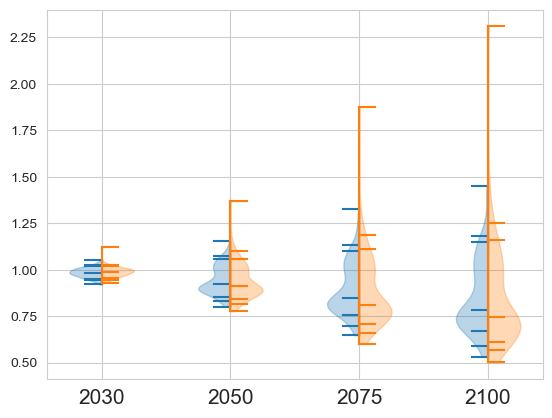

In [10]:
# violinplot 
# fig, ax = plt.subplots()
# ax.violinplot(np.log(np.array([gdp_ref_tmp.values.flatten(), gdp_neg_tmp.values.flatten()])).T)
# plt.show()
edge_colors = ['C0', 'C1']
face_colors = [to_rgba(color, 0.5) for color in edge_colors]
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots()
    for i_year, year in enumerate([2030, 2050,2075,2100]):
        gdp_ref_tmp = gdp_ref[gdp_ref.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()
        gdp_neg_tmp = gdp_neg[gdp_neg.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()
        # ax.violinplot(np.array([gdp_ref_tmp.values.flatten(), gdp_neg_tmp.values.flatten()]).T,
        #               showmedians=True, quantiles= [[0.05, 0.1, 0.9, 0.95],[0.05, 0.1, 0.9, 0.95]]
        #               )
        pc_ref = ax.violinplot(gdp_ref_tmp.values.flatten(), [i_year], side = 'low', 
                    showmedians=True, quantiles= [0.05, 0.1, 0.9, 0.95])
        pc_neg = ax.violinplot(gdp_neg_tmp.values.flatten(), [i_year], side = 'high', 
                    showmedians=True, quantiles= [0.05, 0.1, 0.9, 0.95])
        for pc in pc_ref['bodies']:
            pc.set_facecolor(face_colors[0])
            pc.set_edgecolor(edge_colors[0])
        for pc in pc_neg['bodies']:
            pc.set_facecolor(face_colors[1])
            pc.set_edgecolor(edge_colors[1])
        for prop in ['cmins', 'cmaxes', 'cbars', 'cmedians', 'cquantiles']:
            for i_scen, pc in enumerate([pc_ref, pc_neg]):
                pc[prop].set_color(edge_colors[i_scen])
                # if prop in ['cbars']: 
                    # for line in pc[prop]:
                    # pc[prop].set_linestyle((0, (5, 5)))
                    # pc[prop].set_linsetyle('--')
    ax.set_xticks([0,1,2, 3], ['2030', '2050', '2075', '2100'], fontsize = labelsize_small)
    #ax.set_yticks([0.5,1,1.5,2],[0.5,1,1.5,2], fontsize = labelsize_small)  
    # ax.legend()
    plt.show()

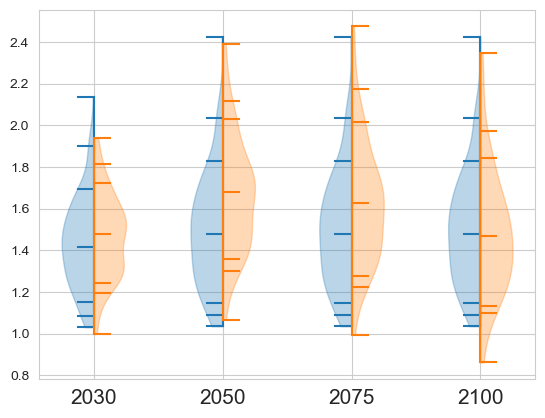

In [11]:
edge_colors = ['C0', 'C1']
face_colors = [to_rgba(color, 0.5) for color in edge_colors]
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots()
    for i_year, year in enumerate([2030, 2050,2075,2100]):
        gdp_ref_tmp = gmt_ds.loc[gmt_ds.index == year, gmt_ds.columns.str.contains('Ref')]
        gdp_neg_tmp = gmt_ds.loc[gmt_ds.index == year, gmt_ds.columns.str.contains('Neg')]
        # ax.violinplot(np.array([gdp_ref_tmp.values.flatten(), gdp_neg_tmp.values.flatten()]).T,
        #               showmedians=True, quantiles= [[0.05, 0.1, 0.9, 0.95],[0.05, 0.1, 0.9, 0.95]]
        #               )
        pc_ref = ax.violinplot(gdp_ref_tmp.values.flatten(), [i_year], side = 'low', 
                    showmedians=True, quantiles= [0.05, 0.1, 0.9, 0.95])
        pc_neg = ax.violinplot(gdp_neg_tmp.values.flatten(), [i_year], side = 'high', 
                    showmedians=True, quantiles= [0.05, 0.1, 0.9, 0.95])
        for pc in pc_ref['bodies']:
            pc.set_facecolor(face_colors[0])
            pc.set_edgecolor(edge_colors[0])
        for pc in pc_neg['bodies']:
            pc.set_facecolor(face_colors[1])
            pc.set_edgecolor(edge_colors[1])
        for prop in ['cmins', 'cmaxes', 'cbars', 'cmedians', 'cquantiles']:
            for i_scen, pc in enumerate([pc_ref, pc_neg]):
                pc[prop].set_color(edge_colors[i_scen])
                # if prop in ['cbars']: 
                    # for line in pc[prop]:
                    # pc[prop].set_linestyle((0, (5, 5)))
                    # pc[prop].set_linsetyle('--')
    ax.set_xticks([0,1,2, 3], ['2030', '2050', '2075', '2100'], fontsize = labelsize_small)
    #ax.set_yticks([0.5,1,1.5,2],[0.5,1,1.5,2], fontsize = labelsize_small)  
    # ax.legend()
    plt.show()

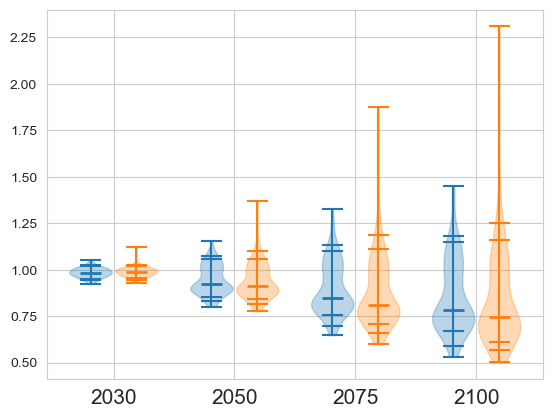

In [12]:
edge_colors = ['C0', 'C1']
face_colors = [to_rgba(color, 0.5) for color in edge_colors]
width = 0.35
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots()
    for i_year, year in enumerate([2030, 2050,2075,2100]):
        gdp_ref_tmp = gdp_ref[gdp_ref.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()
        gdp_neg_tmp = gdp_neg[gdp_neg.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()
        pc_ref = ax.violinplot(gdp_ref_tmp.values.flatten(), [i_year-0.19],  
                    showmedians=True, quantiles= [0.05, 0.1, 0.9, 0.95], widths = width)
        pc_neg = ax.violinplot(gdp_neg_tmp.values.flatten(), [i_year+0.19], 
                    showmedians=True, quantiles= [0.05, 0.1, 0.9, 0.95], widths = width)
        for pc in pc_ref['bodies']:
            pc.set_facecolor(face_colors[0])
            pc.set_edgecolor(edge_colors[0])
        for pc in pc_neg['bodies']:
            pc.set_facecolor(face_colors[1])
            pc.set_edgecolor(edge_colors[1])
        for prop in ['cmins', 'cmaxes', 'cbars', 'cmedians', 'cquantiles']:
            for i_scen, pc in enumerate([pc_ref, pc_neg]):
                pc[prop].set_color(edge_colors[i_scen])
                if prop in ['cmedians']: 
                    pc[prop].set_linewidth(2)
                # if prop in ['cbars']: 
                    # for line in pc[prop]:
                    # pc[prop].set_linestyle((0, (5, 5)))
                    # pc[prop].set_linsetyle('--')
    ax.set_xticks([0,1,2, 3], ['2030', '2050', '2075', '2100'], fontsize = labelsize_small)
    #ax.set_yticks([0.5,1,1.5,2],[0.5,1,1.5,2], fontsize = labelsize_small)  
    # ax.legend()
    plt.show()

### Step 2: Hypothesis testing: Are the Ref and Neg distributions significantly different? 

a. Employ KS test to see if Neg and Ref distributions are significantly different

In [13]:
for year in [2040,2050,2060,2070,2080,2090,2100]: 
  gdp_year_ref = gdp_ref[gdp_ref.year == year]
  gdp_year_neg = gdp_neg[gdp_neg.year == year]
  print(f'Year: {year}',   ks_2samp(gdp_year_ref.loc[:, 'diff_SSP2'].values.flatten(), 
          gdp_year_neg.loc[:, 'diff_SSP2'].values.flatten(), 
          alternative= 'two-sided'
        ))
  # KS test: p-value < 0.05, reject null hypothesis that the two samples are drawn from the same distribution

Year: 2040 KstestResult(statistic=0.01515923566878985, pvalue=0.0536668895124075)
Year: 2050 KstestResult(statistic=0.019299363057324853, pvalue=0.005697396612475834)
Year: 2060 KstestResult(statistic=0.036305732484076425, pvalue=1.9986104605168294e-09)
Year: 2070 KstestResult(statistic=0.045923566878980915, pvalue=7.970912973027381e-15)
Year: 2080 KstestResult(statistic=0.04949044585987261, pvalue=3.781537899065723e-17)
Year: 2090 KstestResult(statistic=0.044904458598726105, pvalue=3.415884048083639e-14)
Year: 2100 KstestResult(statistic=0.036496815286624185, pvalue=1.6060767571105607e-09)


b. Are two randomly chosen subpopulations from ref & neg that have the same eoc temperature significantly different?

2040 KstestResult(statistic=0.17567567567567569, pvalue=0.2043640020406482)
2050 KstestResult(statistic=0.14864864864864866, pvalue=0.3890886157753905)
2060 KstestResult(statistic=0.14864864864864866, pvalue=0.3890886157753905)
2070 KstestResult(statistic=0.17567567567567569, pvalue=0.2043640020406482)
2080 KstestResult(statistic=0.20270270270270271, pvalue=0.0955823533721056)
2090 KstestResult(statistic=0.20270270270270271, pvalue=0.0955823533721056)
2100 KstestResult(statistic=0.1891891891891892, pvalue=0.14175098256680027)


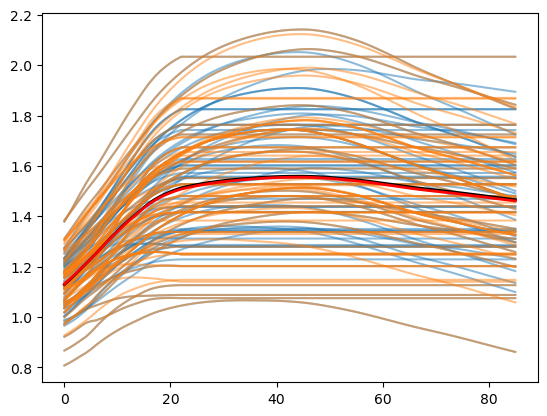

In [14]:
import random 
run_group_a = random.sample(range(0,200), 100)
run_group_b = [i for i in range(200) if i not in run_group_a]

for year in [2040,2050,2060,2070,2080,2090,2100]:
    gmt_ref_a = gmt_ds.loc[:, (gmt_ds.columns.str.contains('Ref')) | (gmt_ds.columns.str.contains('Neg'))].iloc[:, run_group_a].copy().values
    gmt_ref_b = gmt_ds.loc[:,(gmt_ds.columns.str.contains('Ref')) | (gmt_ds.columns.str.contains('Neg'))].iloc[:, run_group_b].copy().values
    gdp_2100_test = gdp_df[ ((gdp_df.scen == 'Ref') | (gdp_df.scen == 'Neg')) & (gdp_df.year == year)].copy()

    ref_pairs  = []
    err = 0.05
    for i in range(gmt_ref_a.shape[1]):
        for j in range(gmt_ref_b.shape[1]):
            if len(ref_pairs) == 0: 
                if (np.abs(gmt_ref_a[0,i]-gmt_ref_b[0,j]) <= err) & (np.abs(gmt_ref_a[-1,i]-gmt_ref_b[-1,j]) <= err):
                    ref_pairs.append([i,j])  
            elif ((not i in np.array(ref_pairs)[:, 0]) & (not j in np.array(ref_pairs)[:, 1])):
                if (np.abs(gmt_ref_a[0,i]-gmt_ref_b[0,j]) <= err) & (np.abs(gmt_ref_a[-1,i]-gmt_ref_b[-1,j]) <= err):
                    ref_pairs.append([i,j])  
    ref_pairs = np.array(ref_pairs, dtype = int)

    run_ids_a = np.array(np.unique(np.array(run_group_a)[ref_pairs[:, 0]]), dtype = int)
    run_ids_b = np.array(np.unique(np.array(run_group_b)[ref_pairs[:, 1]]), dtype = int)

    gdp_test_group_a = gdp_2100_test.loc[:, 'diff_SSP2'].iloc[run_ids_a].values.flatten()
    gdp_test_group_b =  gdp_2100_test.loc[:, 'diff_SSP2'].iloc[run_ids_b].values.flatten()

    print(year, ks_2samp(gdp_test_group_a, 
            gdp_test_group_b, 
            alternative= 'two-sided'
        ))

plt.figure()
plt.plot(gmt_ref_a[:, ref_pairs[:, 0]], color = 'C0', alpha = .5)
plt.plot(gmt_ref_b[:, ref_pairs[:, 1]], color = 'C1', alpha = .5)
plt.plot(np.mean(gmt_ref_a[:, ref_pairs[:, 0]], axis = 1), color = 'black', linewidth = 2)
plt.plot(np.mean(gmt_ref_b[:, ref_pairs[:, 1]], axis = 1), color = 'red', linewidth = 2)
plt.show()
# KS test: p-value > 0.05, accept null hypothesis that the two samples are drawn from the same distribution

### Step 3: Assess degree of deviations

a. Shift Function

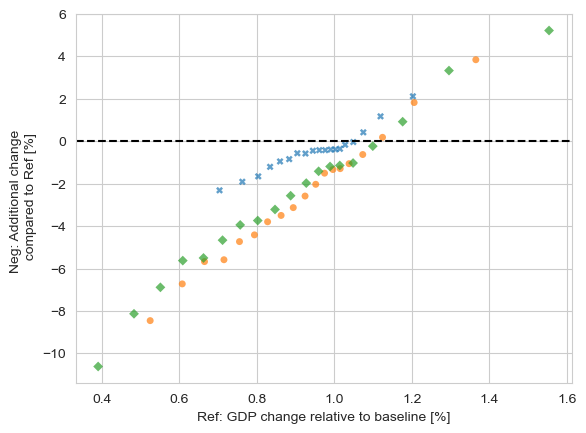

In [14]:
symbols = ['X', 'o', 'D']
with sns.axes_style('whitegrid'):
    plt.figure()
    for i, year in enumerate([2050,2075,2100]):
        ref_quantiles = np.quantile(gdp_ref[gdp_ref.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))
        neg_quantiles = np.quantile(gdp_neg[gdp_neg.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))
        plt.scatter(ref_quantiles, (neg_quantiles-ref_quantiles)/(ref_quantiles)*100, s = 25, marker = symbols[i], alpha  = .7, edgecolor = 'none', facecolor = 'C{}'.format(i))
    plt.axhline(0, color = 'black', linestyle = '--')
    plt.xlabel('Ref: GDP change relative to baseline [%]')
    plt.ylabel('Neg: Additional change \n compared to Ref [%]')
    plt.show()

### Step 4: Generalise results using quantile regression

a. for 2100 

In [15]:
np.arange(0.05, 1, 0.05)[9]

0.5

### Step 5: Visualisations 

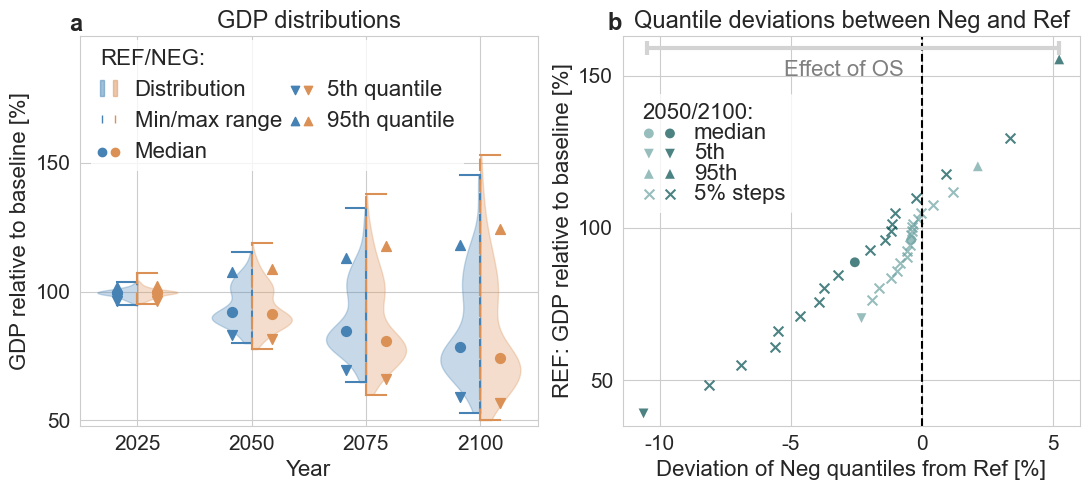

In [45]:

from matplotlib.legend_handler import HandlerTuple
colors = sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.4,1,2))
symbols = ['s', 'X', 'o', 'D']
width = 0.7
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    ax = axes[0]
    edge_colors = [focus_scenarios_color_dict['Ref'], focus_scenarios_color_dict['Neg']]
    face_colors = [to_rgba(color, 0.7) for color in edge_colors]
    for i_year, year in enumerate([2025, 2050,2075,2100]):
        gdp_ref_tmp = gdp_ref[gdp_ref.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
        gdp_neg_tmp = gdp_neg[gdp_neg.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
        gdp_ref_tmp = gdp_ref_tmp[gdp_ref_tmp.values <= 1.1*gdp_ref_tmp.quantile(.99).values[0]]
        gdp_neg_tmp = gdp_neg_tmp[gdp_neg_tmp.values <= 1.1*gdp_neg_tmp.quantile(.99).values[0]]
        # ax.violinplot(np.array([gdp_ref_tmp.values.flatten(), gdp_neg_tmp.values.flatten()]).T,
        #               showmedians=True, quantiles= [[0.05, 0.1, 0.9, 0.95],[0.05, 0.1, 0.9, 0.95]]
        #               )
        pc_ref = ax.violinplot(gdp_ref_tmp.values.flatten(), [i_year], side = 'low', widths = width,)
        pc_neg = ax.violinplot(gdp_neg_tmp.values.flatten(), [i_year], side = 'high', widths = width)
        
        pos_ref = i_year-width/4
        pos_neg = i_year+width/4
        
        for i_q, q in enumerate([0.05,0.5,0.95]): 
            ax.scatter([pos_ref], np.quantile(gdp_ref_tmp.values.flatten(), q = q), s = 50, marker = ['v', 'o', '^'][i_q], color = edge_colors[0])
            ax.scatter([pos_neg], np.quantile(gdp_neg_tmp.values.flatten(), q = q), s = 50, marker = ['v', 'o', '^'][i_q], color = edge_colors[1])
        
        for pc in pc_ref['bodies']:
            pc.set_facecolor(face_colors[0])
            pc.set_edgecolor(edge_colors[0])
        for pc in pc_neg['bodies']:
            pc.set_facecolor(face_colors[1])
            pc.set_edgecolor(edge_colors[1])
        for prop in ['cmins', 'cmaxes', 'cbars']:
            for i_scen, pc in enumerate([pc_ref, pc_neg]):
                pc[prop].set_color(edge_colors[i_scen])
                if prop in ['cmedians']:
                    pc[prop].set_linewidth(2)
                if prop in ['cbars']:
                    pc[prop].set_linestyle((0, (5, 5)))
    ax.fill_between([-1], [0], [0], color = focus_scenarios_color_dict['Ref'], alpha = .5, label = 'Ref')
    ax.fill_between([-1], [0], [0], color = focus_scenarios_color_dict['Neg'], alpha = .5, label = 'Neg')
    ax.plot([-1, -1], [0, 0], marker = '|', linestyle = '', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.plot([-1, -1], [0, 0], marker = '|', linestyle = '', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    ax.scatter([-1],[0], marker = 'o', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.scatter([-1],[0], marker = 'o', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    ax.scatter([-1],[0], marker = 'v', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.scatter([-1],[0], marker = 'v', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    ax.scatter([-1],[0], marker = '^', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.scatter([-1],[0], marker = '^', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [tuple([handles[i] for i in range(j*2, (j+1)*2)]) for j in range(5)]
    new_labels = ['Distribution', 'Min/max range', 'Median', '5th quantile', '95th quantile']
    ax.legend(new_handles, 
              new_labels, 
              loc = 'upper left', 
                fontsize = labelsize_medium, 
                edgecolor = 'none',
                facecolor = [1,1,1,0.7], 
                handler_map={tuple: HandlerTuple(ndivide=None)},
                handlelength = .75,
                ncol = 2,
                title = 'REF/NEG:', 
                title_fontsize = labelsize_medium,
                alignment = 'left',
                bbox_to_anchor = (0, 1.02),
                columnspacing = 0.5,
                )
    ax.set_xlim(-0.5,3.5)
    ax.set_ylim(48, 199)
    ax.set_xticks([0,1,2, 3], ['2025', '2050', '2075', '2100'], fontsize = labelsize_small)
    ax.set_yticks([50,100,150],[50,100,150], fontsize = labelsize_small)  
    ax.set_ylabel('GDP relative to baseline [%]', 
                    fontsize = labelsize_medium)
    ax.set_xlabel('Year', fontsize = labelsize_medium)
    ax.text(-0.6, 201, 'a', fontsize = labelsize_large, fontweight = 'bold')
    ax.set_title('GDP distributions', 
                 fontsize = labelsize_large)
    
    ax = axes[1]
    
    for i, year in enumerate([2050,2100]):
        ref_quantiles = np.quantile(gdp_ref[gdp_ref.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
        neg_quantiles = np.quantile(gdp_neg[gdp_neg.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[0], 
                   ref_quantiles[0], 
                   s = 50, 
                   marker = 'v', 
                   alpha  = .7, 
                   edgecolor = 'none',
                   facecolor = colors[i],
                   label = '5th')
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[-1], 
                   ref_quantiles[-1], 
                s = 50, 
                marker = '^', 
                alpha  = .7, 
                edgecolor = 'none',
                facecolor = colors[i],
                label = '95th')
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[9], 
                ref_quantiles[9], 
                s = 50, 
                marker = 'o', 
                alpha  = .7, 
                edgecolor = 'none',
                facecolor = colors[i],
                label = 'median')
        ax.scatter(
                ((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[1:9], 
                ref_quantiles[1:9], 
                s = 50, 
                marker = 'x', 
                alpha  = .7, 
                facecolor = colors[i], 
                label = year)
        ax.scatter(
                ((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[10:-1], 
                ref_quantiles[10:-1], 
                s = 50, 
                marker = 'x', 
                alpha  = .7, 
                facecolor = colors[i])
    handles, labels = ax.get_legend_handles_labels()
    median_handles = tuple([handles[i] for i in [2, 6]])
    lower_handles = tuple([handles[i] for i in [0, 4]])
    upper_handles = tuple([handles[i] for i in [1, 5]])
    quantile_handles = tuple([handles[i] for i in [3, 7]])
    new_handles =  [median_handles, lower_handles, upper_handles, quantile_handles] 
    # + [tuple([handles[i] for i in range(j*4, (j+1)*4)]) for j in range(3)]
    new_labels = ['median', '5th', '95th', f'5% steps']
    
    ax.axvline(0, color = 'black', linestyle = '--')
    ax.set_ylabel('REF: GDP relative to baseline [%]',
                  fontsize = labelsize_medium)
    ax.set_xlabel('Deviation of Neg quantiles from Ref [%]', 
                  fontsize = labelsize_medium)
    ax.set_yticks([50,100,150], 
                  [50,100,150],
                  fontsize = labelsize_small)
    ax.set_xticks([-10,-5,0,5], 
                  [-10,-5,0,5], 
                  fontsize = labelsize_small)
    ax.legend(new_handles, new_labels, loc = 'upper left',
              bbox_to_anchor = (0, 0.88), 
                fontsize = labelsize_medium, 
                edgecolor = 'none',
                facecolor = [1,1,1,0.7], 
                handler_map={tuple: HandlerTuple(ndivide=None)},
                ncol = 1, 
                columnspacing = 0.7,
                labelspacing = 0.01,
                handlelength = 1.5,
                title = '2050/2100:',
                title_fontsize = labelsize_medium,
                alignment = 'left')
    ax.set_title('Quantile deviations between Neg and Ref',
                 fontsize = labelsize_large)
    ax.text(-12,165, 'b', fontsize = labelsize_large, fontweight = 'bold')
    ax.plot([-10.5,5.2], [159,159], color = 'lightgrey', linestyle = '-', lw = 3)
    ax.scatter([5.2], [159],  marker = '|', s = 100, color = 'lightgrey', lw = 3)
    ax.scatter([-10.5], [159],  marker = '|', s = 100, color = 'lightgrey', lw = 3)
    ax.text( -3, 152,  'Effect of OS', fontsize = labelsize_medium, rotation = 0, va = 'center', ha = 'center', color = 'grey')
    ax.set_ylim(35,163)
    plt.tight_layout()
    plt.savefig(cset.path_GRAPHICS / 'paper' / 'v0' / '003_results.pdf', dpi = 600)
    plt.show()


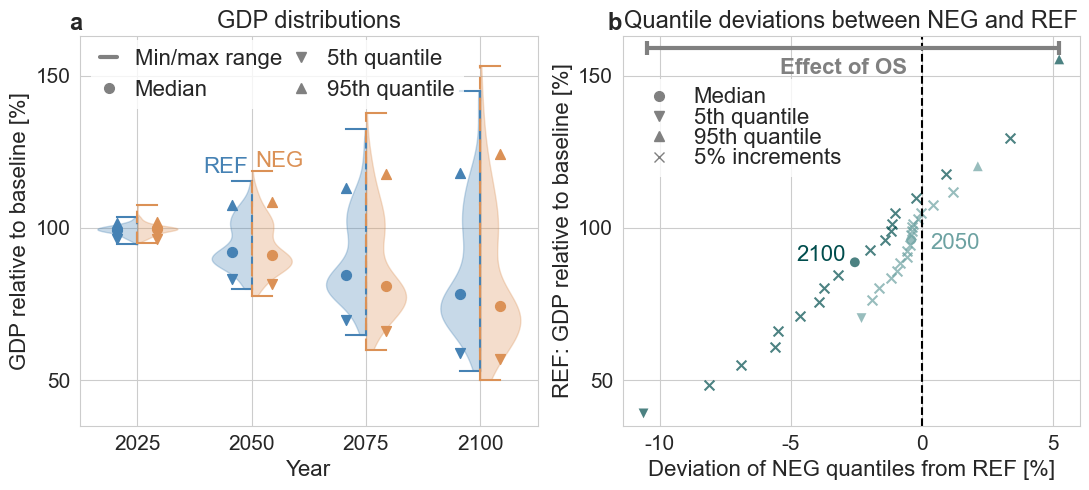

In [87]:

from matplotlib.legend_handler import HandlerTuple
colors = sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.4,1,2))
symbols = ['s', 'X', 'o', 'D']
width = 0.7
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    ax = axes[0]
    edge_colors = [focus_scenarios_color_dict['Ref'], focus_scenarios_color_dict['Neg']]
    face_colors = [to_rgba(color, 0.7) for color in edge_colors]
    for i_year, year in enumerate([2025, 2050,2075,2100]):
        gdp_ref_tmp = gdp_ref[gdp_ref.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
        gdp_neg_tmp = gdp_neg[gdp_neg.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
        gdp_ref_tmp = gdp_ref_tmp[gdp_ref_tmp.values <= 1.1*gdp_ref_tmp.quantile(.99).values[0]]
        gdp_neg_tmp = gdp_neg_tmp[gdp_neg_tmp.values <= 1.1*gdp_neg_tmp.quantile(.99).values[0]]
        # ax.violinplot(np.array([gdp_ref_tmp.values.flatten(), gdp_neg_tmp.values.flatten()]).T,
        #               showmedians=True, quantiles= [[0.05, 0.1, 0.9, 0.95],[0.05, 0.1, 0.9, 0.95]]
        #               )
        pc_ref = ax.violinplot(gdp_ref_tmp.values.flatten(), [i_year], side = 'low', widths = width,)
        pc_neg = ax.violinplot(gdp_neg_tmp.values.flatten(), [i_year], side = 'high', widths = width)
        
        pos_ref = i_year-width/4
        pos_neg = i_year+width/4
        
        for i_q, q in enumerate([0.05,0.5,0.95]): 
            ax.scatter([pos_ref], np.quantile(gdp_ref_tmp.values.flatten(), q = q), s = 50, marker = ['v', 'o', '^'][i_q], color = edge_colors[0])
            ax.scatter([pos_neg], np.quantile(gdp_neg_tmp.values.flatten(), q = q), s = 50, marker = ['v', 'o', '^'][i_q], color = edge_colors[1])
        
        for pc in pc_ref['bodies']:
            pc.set_facecolor(face_colors[0])
            pc.set_edgecolor(edge_colors[0])
        for pc in pc_neg['bodies']:
            pc.set_facecolor(face_colors[1])
            pc.set_edgecolor(edge_colors[1])
        for prop in ['cmins', 'cmaxes', 'cbars']:
            for i_scen, pc in enumerate([pc_ref, pc_neg]):
                pc[prop].set_color(edge_colors[i_scen])
                if prop in ['cmedians']:
                    pc[prop].set_linewidth(2)
                if prop in ['cbars']:
                    pc[prop].set_linestyle((0, (5, 5)))
    ax.fill_between([-1], [0], [0], color = focus_scenarios_color_dict['Ref'], alpha = .5, label = 'Ref')
    ax.fill_between([-1], [0], [0], color = focus_scenarios_color_dict['Neg'], alpha = .5, label = 'Neg')
    ax.plot([-1, -1], [0, 0], marker = '|', linestyle = '', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.plot([-1, -1], [0, 0], marker = '|', linestyle = '', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    ax.scatter([-1],[0], marker = 'o', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.scatter([-1],[0], marker = 'o', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    ax.scatter([-1],[0], marker = 'v', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.scatter([-1],[0], marker = 'v', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    ax.scatter([-1],[0], marker = '^', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.scatter([-1],[0], marker = '^', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    handles, labels = ax.get_legend_handles_labels()
    # new_handles = [tuple([handles[i] for i in range(j*2, (j+1)*2)]) for j in range(1,5)]
    import matplotlib.lines as mlines
    minmax_range = mlines.Line2D([], [], color='grey', marker='none', lw = 3,label='Min/max range')
    median = mlines.Line2D([], [], color='grey', marker='o', lw = 0, markersize = 7, label='Median')
    quantile_05 = mlines.Line2D([], [], color='grey', marker='v', lw = 0, markersize = 7, label='5th quantile')
    quantile_95 = mlines.Line2D([], [], color='grey', marker='^', lw = 0, markersize = 7, label='95th quantile')
    new_handles = [tuple([handles[i] for i in range(j*2, (j+1)*2)]) for j in range(5)]
    new_labels = ['Min/max range', 'Median', '5th quantile', '95th quantile']
    ax.legend(handles = [minmax_range, median, quantile_05, quantile_95],
              loc = 'upper left', 
                fontsize = labelsize_medium, 
                edgecolor = 'none',
                facecolor = [1,1,1,0.7], 
                handler_map={tuple: HandlerTuple(ndivide=None)},
                handlelength = .75,
                ncol = 2,
                alignment = 'left',
                bbox_to_anchor = (0, 1.02),
                columnspacing = 0.5,
                )
    ax.set_xlim(-0.5,3.5)
    # ax.set_ylim(48, 199)
    ax.set_xticks([0,1,2, 3], ['2025', '2050', '2075', '2100'], fontsize = labelsize_small)
    ax.set_yticks([50,100,150],[50,100,150], fontsize = labelsize_small)  
    ax.set_ylabel('GDP relative to baseline [%]', 
                    fontsize = labelsize_medium)
    ax.set_xlabel('Year', fontsize = labelsize_medium)
    ax.text(-0.6, 165, 'a', fontsize = labelsize_large, fontweight = 'bold')
    ax.text(0.58, 118, 'REF', color = focus_scenarios_color_dict['Ref'], fontsize = labelsize_medium)
    ax.text(1.03, 120, 'NEG', color = focus_scenarios_color_dict['Neg'], fontsize = labelsize_medium)
    ax.set_title('GDP distributions', 
                 fontsize = labelsize_large)
    ax.set_ylim(35,163)
    
    ax = axes[1]
    
    for i, year in enumerate([2050,2100]):
        ref_quantiles = np.quantile(gdp_ref[gdp_ref.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
        neg_quantiles = np.quantile(gdp_neg[gdp_neg.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[0], 
                   ref_quantiles[0], 
                   s = 50, 
                   marker = 'v', 
                   alpha  = .7, 
                   edgecolor = 'none',
                   facecolor = colors[i],
                   label = '5th')
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[-1], 
                   ref_quantiles[-1], 
                s = 50, 
                marker = '^', 
                alpha  = .7, 
                edgecolor = 'none',
                facecolor = colors[i],
                label = '95th')
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[9], 
                ref_quantiles[9], 
                s = 50, 
                marker = 'o', 
                alpha  = .7, 
                edgecolor = 'none',
                facecolor = colors[i],
                label = 'median')
        ax.scatter(
                ((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[1:9], 
                ref_quantiles[1:9], 
                s = 50, 
                marker = 'x', 
                alpha  = .7, 
                facecolor = colors[i], 
                label = year)
        ax.scatter(
                ((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[10:-1], 
                ref_quantiles[10:-1], 
                s = 50, 
                marker = 'x', 
                alpha  = .7, 
                facecolor = colors[i])
    handles, labels = ax.get_legend_handles_labels()
    median_handles = tuple([handles[i] for i in [2, 6]])
    lower_handles = tuple([handles[i] for i in [0, 4]])
    upper_handles = tuple([handles[i] for i in [1, 5]])
    quantile_handles = tuple([handles[i] for i in [3, 7]])
    new_handles =  [median_handles, lower_handles, upper_handles, quantile_handles] 
    # + [tuple([handles[i] for i in range(j*4, (j+1)*4)]) for j in range(3)]
    new_labels = ['Median', '5th quantile', '95th quantile', f'5% increments']
    
    ax.axvline(0, color = 'black', linestyle = '--')
    ax.set_ylabel('REF: GDP relative to baseline [%]',
                  fontsize = labelsize_medium)
    ax.set_xlabel('Deviation of NEG quantiles from REF [%]', 
                  fontsize = labelsize_medium)
    ax.set_yticks([50,100,150], 
                  [50,100,150],
                  fontsize = labelsize_small)
    ax.set_xticks([-10,-5,0,5], 
                  [-10,-5,0,5], 
                  fontsize = labelsize_small)
    median = mlines.Line2D([], [], color='grey', marker='o', lw = 0, markersize = 7, label='Median')
    quantile_05 = mlines.Line2D([], [], color='grey', marker='v', lw = 0, markersize = 7, label='5th quantile')
    quantile_95 = mlines.Line2D([], [], color='grey', marker='^', lw = 0, markersize = 7, label='95th quantile')
    steps = mlines.Line2D([], [], color='grey', marker='x', lw = 0, markersize = 7, label='5% increments')
    ax.legend(handles = [median, quantile_05, quantile_95, steps], loc = 'upper left',
              bbox_to_anchor = (0, 0.92), 
                fontsize = labelsize_medium, 
                edgecolor = 'none',
                facecolor = [1,1,1,0.7], 
                handler_map={tuple: HandlerTuple(ndivide=None)},
                ncol = 1, 
                columnspacing = 0.7,
                labelspacing = 0.01,
                handlelength = 1.5,
                alignment = 'left')
    ax.set_title('Quantile deviations between NEG and REF',
                 fontsize = labelsize_large)
    ax.text(-12,165, 'b', fontsize = labelsize_large, fontweight = 'bold')
    ax.plot([-10.5,5.2], [159,159], color = 'grey', linestyle = '-', lw = 3)
    ax.scatter([5.2], [159],  marker = '|', s = 100, color = 'grey', lw = 3)
    ax.scatter([-10.5], [159],  marker = '|', s = 100, color = 'grey', lw = 3)
    ax.text( -3, 152.5,  'Effect of OS', fontsize = labelsize_medium, rotation = 0, va = 'center', ha = 'center', color = 'grey', fontweight = 'bold')
    ax.text(-4.8, 89, '2100', color = colors[1], fontsize = labelsize_medium, ha = 'left')
    ax.text(2.2, 93, '2050', color = colors[0], fontsize = labelsize_medium, ha = 'right')
    ax.set_ylim(35,163)
    plt.tight_layout()
    plt.savefig(cset.path_GRAPHICS / '003_results.pdf', dpi = 600)
    plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
thrshld = 1.35
thrshld_str = '135'



0.5691974700856706
0.7291379930465833
-7.326311470035991


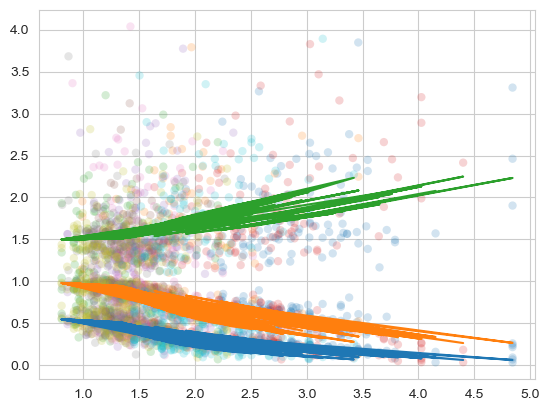

In [ ]:
regression_df = pd.read_csv(cset.path_CHAR_results / f'regression_data_thsld_{thrshld_str}.csv', index_col = 0)

with sns.axes_style('whitegrid'):
    fig, ax  = plt.subplots()
    for q in [0.05, 0.5, 0.95]: 
        y_q = np.log(regression_df.loc[:, ['scen_run', 'diff_SSP2']].groupby('scen_run').quantile(q).values.flatten())
        predictors_q = regression_df.loc[:, ~regression_df.columns.isin(['iso', 'diff_SSP2', 'model_id'])].groupby('scen_run').median()

        # Define predictor variable space 
        predictors = ['tas_soc', 'tas_baseline', 'gmt_eoc', 'gmt_exc', 'gmt_soc']

        # Generate second-order terms
        poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
        X_poly     = poly.fit_transform(predictors_q[predictors])

        # Create a predictor matrix
        poly_feature_names  = poly.get_feature_names_out(predictors)
        predictor_df        = pd.DataFrame(X_poly, columns = poly_feature_names)
        predictors_q.index = predictor_df.index

        # interactions with tas_baseline 
        interaction_terms   = [f for f in poly_feature_names if (('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2'))]
        # Combine original predictors, interaction terms, and polynomial features 
        all_predictors     = list(predictors) + list(interaction_terms) + list([f+'^2' for f in predictors])

        # intercept matrix for country fixed effects  
        n_countries = int(len(regression_df)/1000)
        X_intercept = np.zeros((len(regression_df), n_countries))
        for i in range(n_countries):
            X_intercept[i*1000:(i+1)*1000, i] = 1
            
        # selected predictors 
        sel_predictors = ['gmt_eoc', 'gmt_exc']

        # predicotr matrix 
        X = predictor_df.loc[:, sel_predictors].values
        
        from sklearn.linear_model import LinearRegression
        qr = LinearRegression(fit_intercept = True).fit(X, y_q)
        

        for i in range(10):
            ax.scatter(predictors_q.loc[:, 'gmt_eoc'][i*100:(i+1)*100], np.exp(y_q)[i*100:(i+1)*100], color = f'C{i}', label = f'{q}', alpha = 0.2, edgecolor = 'none')
        ax.plot(predictors_q.loc[:, 'gmt_eoc'], np.exp(qr.predict(X)), label = f'{q}')
        
        print(r2_score(qr.predict(X), y_q))
        
    plt.show()


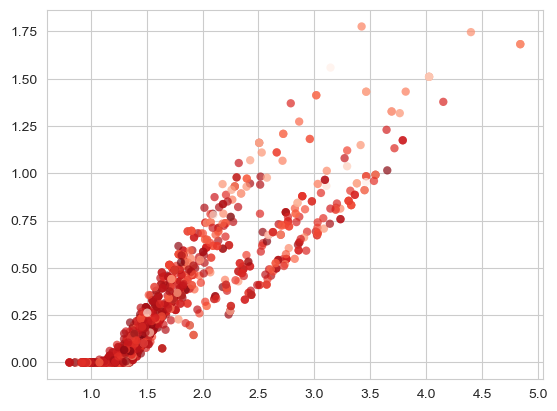

In [ ]:
y_q = np.log(regression_df.loc[:, ['scen_run', 'diff_SSP2']].groupby('scen_run').quantile(0.95).values.flatten())
predictors_q = regression_df.loc[:, ~regression_df.columns.isin(['iso', 'diff_SSP2', 'model_id'])].groupby('scen_run').median()
y_q_std = (y_q - np.min(y_q))/(np.max(y_q) - np.min(y_q))
color_arr = sns.color_palette("Reds_r", as_cmap=True)(y_q_std)

with sns.axes_style('whitegrid'):
    fig, ax  = plt.subplots()
    ax.scatter(predictors_q.loc[:, 'gmt_eoc'].values.flatten(), 
                predictors_q.loc[:, 'gmt_exc'].values.flatten(), 
                c = color_arr, 
                alpha = 0.7, 
                edgecolor = 'none')
    plt.show()
        

In [ ]:
predictor_df.loc[:, 'gmt_exc'].values.min()

0.0

In [ ]:
Zreg.max()

0.6398870382646761

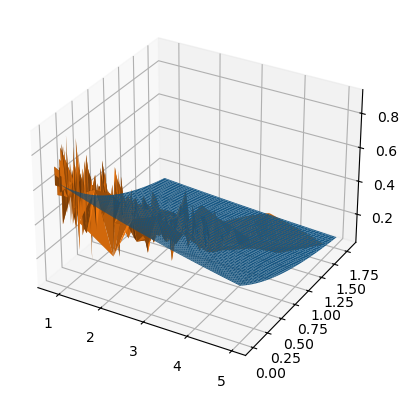

In [ ]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

ax = plt.figure().add_subplot(projection='3d')

for i_q, q in enumerate([0.1]):
    y_q = np.log(regression_df.loc[:, ['scen_run', 'diff_SSP2']].groupby('scen_run').quantile(q).values.flatten())
    # Plot the 3D surface
    
    # plot on regular grid
    sel_predictors = ['gmt_eoc', 'gmt_exc']

    # predicotr matrix 
    X = predictor_df.loc[:, sel_predictors].values
    from sklearn.linear_model import LinearRegression
    qr = LinearRegression(fit_intercept = True).fit(X, y_q)
    Xreg = np.linspace(0.8,5,100)
    Yreg = np.linspace(0,1.8,100) 
    x, y = np.meshgrid(Xreg, Yreg)
    Zreg = np.exp(qr.predict(np.array([x.reshape(-1), y.reshape(-1)]).T)).reshape(100,100)
    ax.plot_surface(x,y, Zreg, edgecolor= 'none', )
    
    X, Y, Z = predictors_q.loc[:, 'gmt_eoc'].values.flatten(), predictors_q.loc[:, 'gmt_exc'].values.flatten(), np.exp(y_q)
    ax.plot_trisurf(X, Y, Z, edgecolor= 'none', )
# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph
# ax.contourf(X, Y, Z, zdir='z', offset=-100, cmap='coolwarm')
# ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap='coolwarm')
# ax.contourf(X, Y, Z, zdir='y', offset=40, cmap='coolwarm')

# ax.set(xlim=(-40, 40), ylim=(-40, 40), zlim=(-100, 100),
#        xlabel='X', ylabel='Y', zlabel='Z')

plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
qr = LinearRegression(fit_intercept = True).fit(X, y_q)

plt.figure()
plt.scatter(predictor_df.loc[:, 'gmt_exc'].values, 
            y_q)
plt.plot(predictor_df.loc[:, 'gmt_exc'].values, 
         qr.predict(X), 
         color = 'black')
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[3.1931 2.4112 3.306  2.4112 2.6126 2.8531 2.5089 2.5089 4.8419 4.8419
 4.8419 2.8588 2.9268 2.8588 3.7904 3.7904 2.9347 3.4487 3.4487 2.5813
 3.0129 2.7504 2.7504 3.2335 2.7504 2.3781 2.3781 3.2318 3.7161 2.8653
 2.8653 3.3802 3.3802 2.7708 3.2335 2.6296 3.024  3.024  2.6601 2.6601
 3.4629 3.4629 3.5466 3.5466 3.5466 2.2326 3.0302 3.0302 3.0302 2.5732
 2.5732 2.5732 1.9193 1.9193 2.7217 2.4307 3.2014 2.9079 3.3213 2.5948
 3.1907 3.1907 3.4617 3.0269 3.1429 2.8777 3.0796 3.3294 2.7455 2.7375
 2.6768 2.6768 2.6768 4.1531 3.0851 2.2462 2.2462 2.2462 3.3294 3.3618
 3.3618 2.4358 2.4358 2.4358 2.7273 2.2531 2.2531 3.533  2.489  3.3294
 3.0294 2.6101 3.6519 2.8242 2.5614 3.1387 2.6539 2.6539 3.306  3.306
 1.1173 1.7835 1.3596 1.7587 1.7587 1.7587 1.4114 1.4114 1.8014 1.8014
 1.8014 1.8014 1.3573 1.475  1.475  1.5174 1.8649 1.8649 2.0918 2.0918
 1.533  1.9695 1.9695 1.3573 1.9722 2.9592 2.9592 1.6497 1.7714 1.4313
 1.6273 1.6273 1.6735 3.4632 1.9337 3.4632 1.1983 1.2375 2.2734 1.5478
 2.5377 0.9939 0.9939 0.9939 1.3671 1.8512 1.3671 2.06   1.4412 1.6139
 1.7168 2.1397 1.4936 2.2361 2.2361 2.2361 1.8512 1.5617 1.4167 1.3929
 1.5651 1.9845 1.8194 1.6687 1.8127 1.8127 1.2973 1.518  1.1791 1.1791
 1.3409 2.715  2.1813 2.1813 1.7537 1.9082 1.9082 1.9082 2.3177 1.638
 1.638  1.927  1.7685 1.7685 1.8845 1.8845 1.406  1.406  1.406  1.7835
 1.2575 2.5134 2.2047 2.0767 2.0767 2.0689 2.5148 1.7149 1.6743 1.2639
 1.0937 1.3282 1.7178 1.7977 1.7977 1.7977 1.3017 1.3017 1.1781 1.1781
 1.4275 1.4275 1.2678 1.1157 0.9367 0.9367 0.9606 1.2034 0.9256 1.1093
 1.1093 1.5331 1.2437 1.5927 1.2437 1.4953 1.4953 1.4953 1.908  1.8652
 1.0509 0.9168 0.9168 1.0238 1.2151 0.972  0.972  1.2437 1.2437 1.3187
 1.6578 1.6578 2.0178 1.179  1.2018 1.3281 1.2018 1.2018 1.2018 1.9832
 1.0966 1.0966 1.4379 1.4379 1.4379 1.0983 1.0075 0.9415 0.9415 1.3723
 1.3723 1.0488 1.6557 2.1824 2.1824 1.3492 1.6885 1.6058 1.8477 1.26
 1.26   1.4314 1.827  1.4913 1.4913 1.4913 1.4671 1.4671 1.2005 1.3751
 1.3751 1.3613 1.4251 1.6129 2.2055 2.2055 2.2055 2.2055 0.8087 1.4212
 0.8087 1.2249 1.2799 1.2799 1.399  1.399  1.399  1.4347 1.7178 1.7178
 2.8916 2.5399 4.026  2.3198 3.2928 2.7643 2.7643 2.4057 2.839  3.0302
 3.0302 2.18   2.8916 3.2933 2.5329 1.9715 2.865  2.6989 2.6989 2.6989
 3.6456 2.1033 2.1033 2.8916 3.2702 2.0363 2.0363 1.8856 1.8856 2.8323
 2.8323 2.0237 4.4001 2.3594 2.9164 1.8485 2.9777 2.9777 3.7638 1.9535
 2.2182 2.3644 2.3644 2.3644 2.3644 3.1071 2.7368 3.6909 3.6909 2.576
 2.2165 2.2165 2.2165 2.7441 2.7441 2.7441 2.3687 2.826  2.3922 3.1108
 2.6804 2.8493 2.8493 3.4134 2.2008 2.7632 2.589  2.7048 2.589  2.1135
 2.1135 2.4242 2.4242 2.6293 2.6293 2.6293 2.7049 2.3198 2.2944 2.3198
 3.0943 3.0943 2.352  2.352  1.6386 1.6386 1.6386 2.7734 2.7734 3.0586
 2.2098 2.2098 2.3332 2.3332 2.521  2.41   3.8167 2.1218 4.026  4.026
 1.4907 1.326  1.5901 1.326  1.326  1.326  1.0582 1.404  1.2858 1.3142
 1.099  1.099  1.9116 1.2583 1.2583 1.4803 1.1788 1.5631 1.5631 1.5631
 1.3471 1.6363 1.6363 1.8327 2.0908 1.4466 1.2964 1.2964 1.6007 1.6037
 1.6037 1.6037 1.1286 1.1267 1.5747 1.1267 2.1898 1.8431 1.0309 1.6917
 1.6917 0.8612 0.8612 1.8944 1.725  0.9751 1.725  1.5182 1.3501 1.3501
 1.1348 1.3413 1.4731 1.4731 1.6487 1.8429 1.8275 1.8429 1.6226 1.2314
 1.2314 2.14   1.7317 1.7317 1.2971 1.3864 1.4289 1.8275 1.4289 1.3098
 1.3098 1.9573 1.1987 1.1987 2.3444 2.3444 1.1552 1.2456 1.4418 1.4683
 1.4683 1.4683 1.4683 1.4683 1.4683 1.1447 1.6865 1.9667 1.2309 1.326
 1.5486 1.7671 1.3204 1.2428 1.4515 1.4515 1.5008 1.6152 1.1822 1.5901
 1.6554 1.5278 1.4148 1.5278 1.14   1.0348 1.6018 1.6018 1.7247 1.7247
 1.5234 1.5896 1.6738 1.5896 1.2024 1.2024 1.417  1.417  1.417  1.2288
 1.572  1.6183 1.6183 1.6738 1.2798 1.2798 2.0117 1.4403 1.4403 1.825
 1.825  1.4368 1.1264 1.1264 1.6738 1.2011 1.2011 2.0335 2.0335 2.0335
 2.0335 1.1476 1.641  1.3831 1.8699 2.4244 1.3295 1.4544 1.6153 1.5575
 1.3495 1.8871 1.2531 1.3423 1.3423 1.5538 1.3115 1.2861 1.7632 1.7632
 1.7632 1.7632 1.6276 1.7506 2.1163 1.6801 1.7139 1.5278 1.7139 1.2486
 1.0874 1.0874 1.0874 1.5516 1.5516 1.7427 1.7974 1.3376 1.5278 1.3376
 1.3376 1.4381 1.4802 1.4802 1.4802 1.4802 1.0748 1.0748 1.0748 1.5278
 1.2489 1.2489 1.2489 1.2489 1.2489 1.8667 1.279  1.279  1.4691 1.4148
 1.3368 1.1623 1.7961 1.5105 1.5105 1.3839 1.3839 0.9057 1.5545 1.5545
 1.3948 1.3948 1.0935 1.1077 1.9043 1.9043 1.5981 2.2514 2.2514 1.817
 1.817  1.1464 1.1888 1.0935 1.7116 1.7116 2.5185 1.293  1.5985 1.8686
 1.4188 1.4188 1.3179 1.691  1.6047 1.3566 1.164  1.509  1.509  1.509
 1.509  1.5816 1.3087 1.3087 1.3087 1.513  1.9786 1.1935 1.8147 1.8147
 1.6401 1.6401 1.1342 1.1342 1.4237 1.4237 1.513  1.4237 2.0049 2.0049
 1.3758 1.3758 1.3758 1.205  1.8013 1.8013 1.7305 1.5374 2.0107 1.2344
 1.8992 1.8992 1.2815 1.2815 1.2485 1.448  1.6348 1.3725 1.5374 2.1304
 2.1304 1.4319 1.4319 1.5423 1.2613 1.314  2.1417 2.1417 1.4618 1.2978
 1.4859 1.4859 1.5296 1.7354 1.7354 1.2918 1.517  1.517  1.4125 1.7961
 1.473  1.8232 1.2808 2.2661 1.2976 1.212  1.2192 1.2192 1.4239 1.3068
 1.3068 1.3068 1.473  1.2347 1.3628 1.3628 1.4647 1.4647 1.4077 1.0256
 1.0256 1.4887 1.0967 1.2103 1.0967 1.0967 1.2511 1.149  1.149  1.3658
 1.3658 1.4529 1.7742 1.7742 1.2724 1.7742 1.1142 1.3625 1.3625 1.3625
 1.0525 1.0525 1.0465 1.0465 0.8698 0.9483 0.8698 1.1747 0.9441 0.9441
 0.9441 1.3803 1.3311 1.5766 1.5766 1.4334 1.3216 1.1369 1.1369 1.1369
 1.7969 1.6917 1.6639 1.1088 1.1088 1.735  1.5449 1.3216 1.9244 2.1421
 1.0769 1.1728 0.9779 1.5456 1.3013 1.3013 1.6822 1.1032 1.3216 1.1032
 1.8965 1.0172 1.0172 1.0959 1.0959 1.3935 1.2058 1.2058 0.8135 1.8232
 1.2854 1.1672 1.1961 1.1961 1.3318 1.572  1.2203 1.3726 1.5035 1.5035
 1.0642 0.8576 1.4068 2.2881 2.2881 2.2881 1.4088 1.7084 1.1363 0.9152
 1.8298 1.1691 1.1212 1.1938 1.3076 1.0529 1.0529 1.7651 1.7132 1.7132
 1.4935 1.4935 1.4935 1.1212 1.4935 1.5868 1.5868 1.0303 1.0303 1.0382
 1.0382 1.3238 1.1204 1.6282 1.1212 1.6282 1.015  1.3854 1.3854 1.3854
 1.194  1.194  1.3867 0.9832 2.0246 1.0339 2.0246 0.9968 0.9968 0.9968
 0.9968 1.448  1.1669 1.2324 1.9183 0.8085 1.3596 0.8085 1.2446 1.1686
 1.1686 1.1686 1.2065 1.2065 1.2196 1.2196 1.2196 1.3596 0.948  0.948
 1.3524 1.5903 1.5903 1.5903 1.0817 1.6977 1.6977 1.3154 0.9175 1.3163
 0.9703 1.3336 1.3892 1.3892 1.5129 1.2981 1.0771 0.9557 0.9557 0.9175
 1.482  1.482  1.482  1.2471 1.2981 1.2981 0.9193 2.0219 2.0219 1.4068
 1.8666 2.3043 2.0684 2.3043 2.0704 2.3235 2.5062 2.5062 2.5062 1.6657
 1.7047 1.8744 1.8666 3.0169 3.0169 2.7215 2.7215 1.7045 1.7045 1.6437
 1.4576 1.5511 1.5511 2.5289 1.5511 1.6491 1.6491 2.2092 1.7363 1.5325
 2.0029 2.663  2.663  3.4224 2.1071 1.6926 1.6926 2.0369 1.9233 1.9233
 2.4257 3.1442 2.1787 2.0164 1.7017 1.9005 1.7017 1.7017 1.7839 2.0724
 2.0724 2.1855 1.8868 1.3514 2.3956 2.3956 1.9005 1.5185 2.04   2.04
 1.5579 1.5688 1.5688 1.8101 1.8177 1.8177 1.5051 1.9005 1.7212 1.7212
 1.7212 1.7212 1.7212 1.7212 1.6353 1.6353 2.0899 2.2241 1.7906 1.7866
 1.7866 1.7866 1.7866 2.1784 2.8639 1.8123 1.4595 1.4595 1.4595 1.6181
 1.4595 2.2589 2.3931 2.7887 2.1476 1.8069 1.7505 1.7505 2.5757 2.0966].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

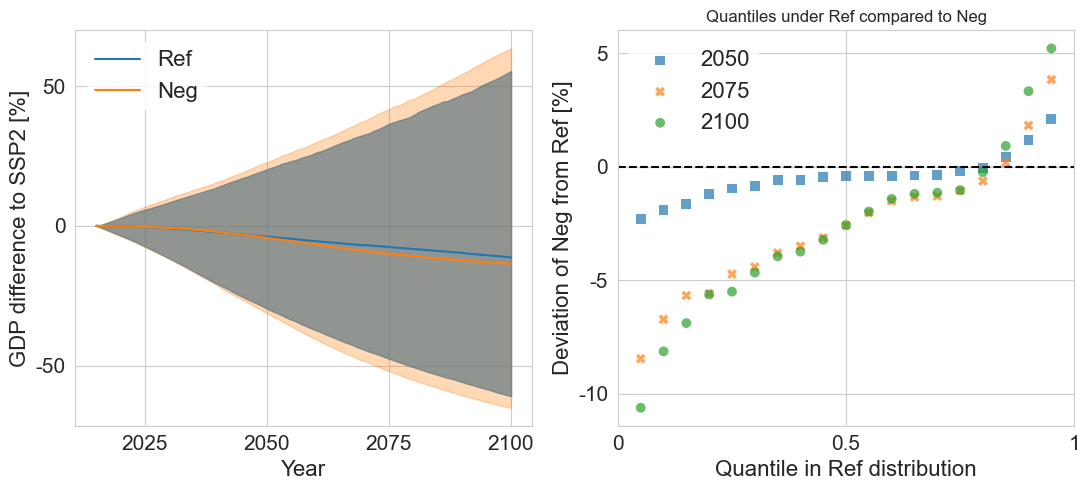

In [ ]:
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    ax = axes[0]
    ((gdp_ref_agg.loc[:, 'median']-1)*100).plot(ax=ax, label='Ref', color='C0')
    ((gdp_neg_agg.loc[:, 'median']-1)*100).plot(ax=ax, label='Neg', color='C1')
    ax.fill_between(gdp_ref_agg.index, (gdp_ref_agg.loc[:, 'q05']-1)*100, (gdp_ref_agg.loc[:, 'q95']-1)*100, color='C0', alpha=0.7)
    ax.fill_between(gdp_neg_agg.index, (gdp_neg_agg.loc[:, 'q05']-1)*100, (gdp_neg_agg.loc[:, 'q95']-1)*100, color='C1', alpha=0.3)
    ax.set_xlabel('Year', 
                    fontsize = labelsize_medium)
    ax.set_ylabel('GDP difference to SSP2 [%]',
                    fontsize = labelsize_medium)
    ax.set_xticks([2025, 2050, 2075, 2100],
                    [2025, 2050, 2075, 2100],
                    fontsize = labelsize_small)
    ax.set_yticks([-50,0,50], 
                    [-50,0,50],
                    fontsize = labelsize_small)
    ax.legend(loc = 'upper left', 
                fontsize = labelsize_medium, 
                edgecolor = 'none',
                facecolor = [1,1,1,0.7])
    ax = axes[1]
    for i, year in enumerate([2050,2075,2100]):
        ref_quantiles = np.quantile(gdp_ref[gdp_ref.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))
        neg_quantiles = np.quantile(gdp_neg[gdp_neg.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))
        ax.scatter(np.arange(0.05, 1, 0.05), 
                   (neg_quantiles-ref_quantiles)/(ref_quantiles)*100, 
                   s = 50, 
                   marker = symbols[i], 
                   alpha  = .7, 
                   edgecolor = 'none', 
                   facecolor = 'C{}'.format(i),
                   label = str(year))
    ax.axhline(0, color = 'black', linestyle = '--')
    ax.set_xlabel('Quantile in Ref distribution',
                  fontsize = labelsize_medium)
    ax.set_ylabel('Deviation of Neg from Ref [%]', 
                  fontsize = labelsize_medium)
    ax.set_xticks([0,0.5,1], 
                  [0,0.5,1],
                  fontsize = labelsize_small)
    ax.set_yticks([-10,-5,0,5], 
                  [-10,-5,0,5], 
                  fontsize = labelsize_small)
    ax.legend(loc = 'upper left',
                fontsize = labelsize_medium, 
                edgecolor = 'none',
                facecolor = [1,1,1,0.7])
    ax.set_title('Quantiles under Ref compared to Neg')
    plt.tight_layout()
    plt.show()
